# **EV ADOPTION FORECASTING MODEL**
# Electric Vehicle Population Analysis and Prediction
# ===========================================
## **1. SETUP AND DATA LOADING**
# ===========================================

In [1]:
# Import Required Libraries
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/Electric_Vehicle_Population_Size_History_By_County_.csv")

In [5]:
# Check Dataset Dimensions
print("Dataset Shape:", df.shape)

Dataset Shape: (20819, 10)


In [6]:
# Preview the Dataset
print("\n=== Dataset Preview ===")
print(df.head())


=== Dataset Preview ===
                Date          County State Vehicle Primary Use  \
0  September 30 2022       Riverside    CA           Passenger   
1   December 31 2022  Prince William    VA           Passenger   
2    January 31 2020          Dakota    MN           Passenger   
3       June 30 2022           Ferry    WA               Truck   
4       July 31 2021         Douglas    CO           Passenger   

  Battery Electric Vehicles (BEVs) Plug-In Hybrid Electric Vehicles (PHEVs)  \
0                                7                                        0   
1                                1                                        2   
2                                0                                        1   
3                                0                                        0   
4                                0                                        1   

  Electric Vehicle (EV) Total Non-Electric Vehicle Total Total Vehicles  \
0                           

In [8]:
# Data Types and Missing Values
print("\n=== Dataset Info ===")
print(df.info())

print("\n=== Missing Values ===")
print(df.isnull().sum())


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1

# ==============================================
## **2. DATA PREPROCESSING AND OUTLIER HANDLING**
# ==============================================

In [9]:
# Outlier Detection and Handling for Percent Electric Vehicles
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

In [10]:
# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f'\nOutlier Boundaries:')
print(f'Lower bound: {lower_bound:.4f}')
print(f'Upper bound: {upper_bound:.4f}')


Outlier Boundaries:
Lower bound: -3.5175
Upper bound: 6.9025


In [11]:
# Identify outliers before treatment
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print(f"Number of outliers in 'Percent Electric Vehicles': {outliers.shape[0]}")

Number of outliers in 'Percent Electric Vehicles': 2476


In [12]:
# Date Processing
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].notnull()]

In [13]:
# Remove rows where target is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

In [15]:
# Fill missing categorical values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

print(f"\nMissing values after filling:")
print(df[['County', 'State']].isnull().sum())


Missing values after filling:
County    0
State     0
dtype: int64


In [16]:
# Cap outliers (winsorization)
df['Percent Electric Vehicles'] = np.where(
    df['Percent Electric Vehicles'] > upper_bound, upper_bound,
    np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound,
             df['Percent Electric Vehicles'])
)

In [17]:
# Verify outlier treatment
outliers_after = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print(f"Number of outliers after capping: {outliers_after.shape[0]}")

Number of outliers after capping: 0


In [18]:
# Convert numeric columns
cols_to_convert = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"\n=== Numeric Data Summary ===")
print(df[cols_to_convert].describe())


=== Numeric Data Summary ===
       Battery Electric Vehicles (BEVs)  \
count                      20266.000000   
mean                          25.855176   
std                          102.004224   
min                            0.000000   
25%                            0.000000   
50%                            1.000000   
75%                            2.000000   
max                          999.000000   

       Plug-In Hybrid Electric Vehicles (PHEVs)  Electric Vehicle (EV) Total  \
count                              20468.000000                 20119.000000   
mean                                  21.790942                    31.623093   
std                                   92.309729                   115.742017   
min                                    0.000000                     0.000000   
25%                                    0.000000                     1.000000   
50%                                    1.000000                     1.000000   
75%                   

# ======================================
## **3. EXPLORATORY DATA ANALYSIS**
# ======================================

In [19]:
# Top and Bottom Counties by EV Count
top_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values(ascending=False).head(3)
bottom_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values().head(3)

print(f"\n=== County Analysis ===")
print("Top 3 Counties by EV Total:\n", top_counties)
print("\nBottom 3 Counties by EV Total:\n", bottom_counties)


=== County Analysis ===
Top 3 Counties by EV Total:
 County
Clallam      39839.0
Jefferson    39683.0
San Juan     39309.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties by EV Total:
 County
Brown         1.0
Union         1.0
Hood River    1.0
Name: Electric Vehicle (EV) Total, dtype: float64


In [23]:
# Vehicle Distribution Visualization
print(f"\n=== Vehicle Distribution Analysis ===")

# Calculate totals with error checking
bev_total = df['Battery Electric Vehicles (BEVs)'].fillna(0).sum()
phev_total = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].fillna(0).sum()
ev_total = df['Electric Vehicle (EV) Total'].fillna(0).sum()
non_ev_total = df['Non-Electric Vehicle Total'].fillna(0).sum()

print(f"BEV Total: {bev_total:,.0f}")
print(f"PHEV Total: {phev_total:,.0f}")
print(f"EV Total: {ev_total:,.0f}")
print(f"Non-EV Total: {non_ev_total:,.0f}")


=== Vehicle Distribution Analysis ===
BEV Total: 523,981
PHEV Total: 446,017
EV Total: 636,225
Non-EV Total: 1,857,576


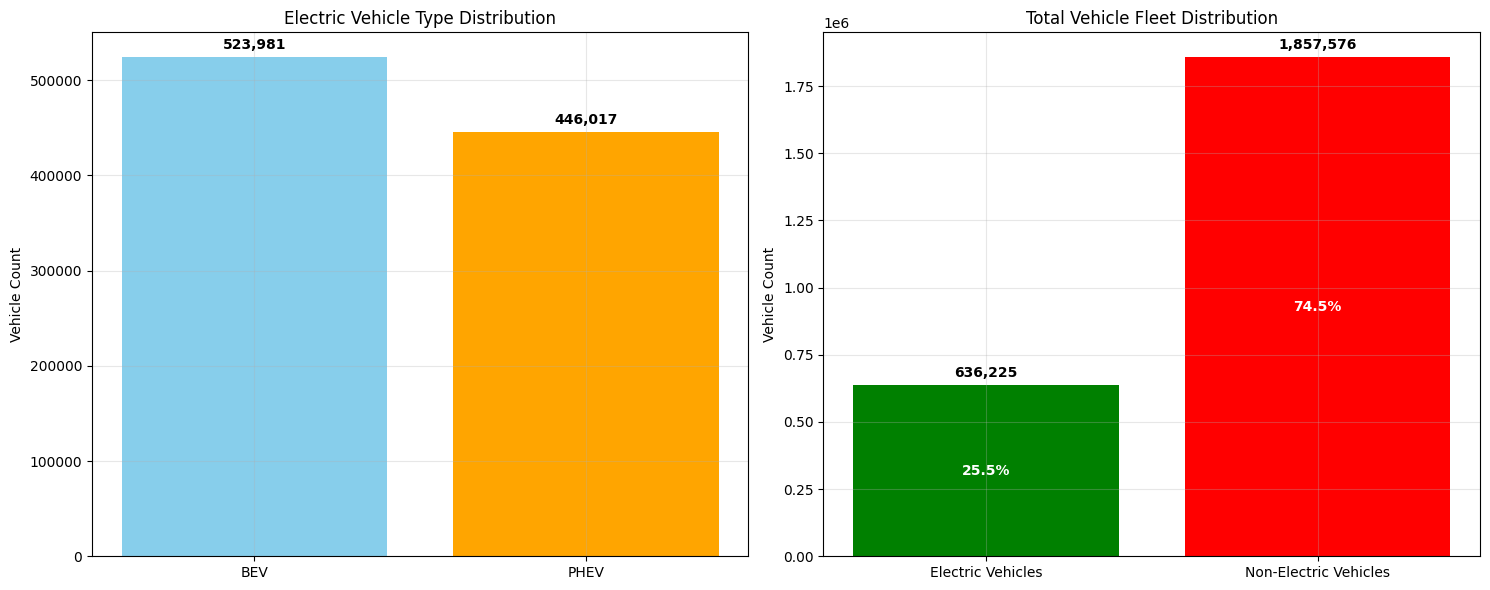

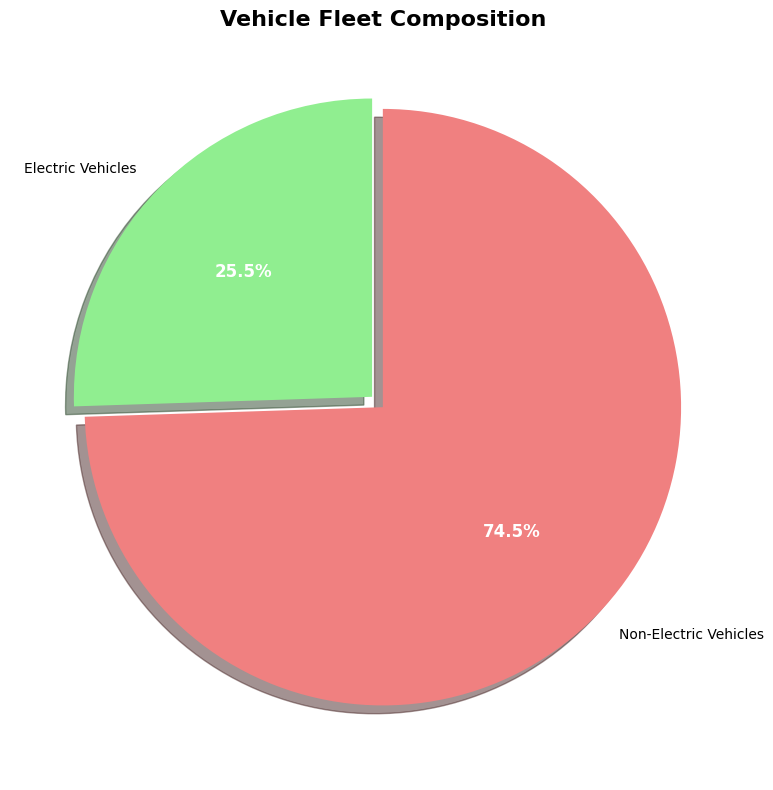

In [25]:
# Check if we have valid data
if ev_total > 0 or non_ev_total > 0:
    # Create stacked bar chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Chart 1: EV Type Breakdown
    if bev_total > 0 or phev_total > 0:
        ev_types = ['BEV', 'PHEV']
        ev_counts = [bev_total, phev_total]
        colors1 = ['skyblue', 'orange']

        ax1.bar(ev_types, ev_counts, color=colors1)
        ax1.set_ylabel('Vehicle Count')
        ax1.set_title('Electric Vehicle Type Distribution')
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(ev_counts):
            if v > 0:
                ax1.text(i, v + max(ev_counts) * 0.01, f'{v:,.0f}',
                        ha='center', va='bottom', fontweight='bold')
    else:
        ax1.text(0.5, 0.5, 'No EV breakdown data available',
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Electric Vehicle Type Distribution')

    # Chart 2: Total Vehicle Categories
    if ev_total > 0 and non_ev_total > 0:
        vehicle_types = ['Electric Vehicles', 'Non-Electric Vehicles']
        vehicle_counts = [ev_total, non_ev_total]
        colors2 = ['green', 'red']

        ax2.bar(vehicle_types, vehicle_counts, color=colors2)
        ax2.set_ylabel('Vehicle Count')
        ax2.set_title('Total Vehicle Fleet Distribution')
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(vehicle_counts):
            ax2.text(i, v + max(vehicle_counts) * 0.01, f'{v:,.0f}',
                    ha='center', va='bottom', fontweight='bold')

        # Add percentage labels
        total_vehicles = sum(vehicle_counts)
        for i, v in enumerate(vehicle_counts):
            percentage = (v / total_vehicles) * 100
            ax2.text(i, v / 2, f'{percentage:.1f}%',
                    ha='center', va='center', fontweight='bold', color='white')
    else:
        ax2.text(0.5, 0.5, 'No total vehicle data available',
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Total Vehicle Fleet Distribution')

    plt.tight_layout()
    plt.show()

    # Create pie chart as alternative visualization
    if ev_total > 0 and non_ev_total > 0:
        fig, ax = plt.subplots(figsize=(10, 8))

        # Pie chart data
        sizes = [ev_total, non_ev_total]
        labels = ['Electric Vehicles', 'Non-Electric Vehicles']
        colors = ['lightgreen', 'lightcoral']
        explode = (0.05, 0)  # explode EV slice slightly

        wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors,
                                         autopct='%1.1f%%', startangle=90,
                                         explode=explode, shadow=True)

        # Enhance text
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(12)

        ax.set_title('Vehicle Fleet Composition', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ Warning: No vehicle data found for visualization")
    print("Please check if the dataset contains the required columns with valid data")

# =====================================
## **4. FEATURE ENGINEERING**
# =====================================

In [26]:
# Time-based features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['numeric_date'] = df['Date'].dt.year * 12 + df['Date'].dt.month

# Encode categorical features
le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])

# Sort data for time series feature creation
df = df.sort_values(['County', 'Date'])
df['months_since_start'] = df.groupby('County').cumcount()

# Create lag features (1-3 months)
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

# Rolling average (3-month)
df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())

# Percent change features
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=1, fill_method=None)
df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=3, fill_method=None)

# Clean infinite values
df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Cumulative and growth slope features
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan)
)

# Remove rows with missing lag features
df = df.dropna().reset_index(drop=True)

# Save preprocessed data
df.to_csv('/content/preprocessed_ev_data.csv', index=False)
print(f"\nPreprocessed data saved. Final dataset shape: {df.shape}")
print(f"Dataset preview:")
print(df.head())


Preprocessed data saved. Final dataset shape: (12573, 23)
Dataset preview:
        Date County State Vehicle Primary Use  \
0 2018-05-31    Ada    ID           Passenger   
1 2018-06-30    Ada    ID           Passenger   
2 2018-07-31    Ada    ID           Passenger   
3 2018-08-31    Ada    ID           Passenger   
4 2018-09-30    Ada    ID           Passenger   

   Battery Electric Vehicles (BEVs)  Plug-In Hybrid Electric Vehicles (PHEVs)  \
0                               0.0                                       2.0   
1                               0.0                                       2.0   
2                               0.0                                       2.0   
3                               0.0                                       2.0   
4                               0.0                                       2.0   

   Electric Vehicle (EV) Total  Non-Electric Vehicle Total  Total Vehicles  \
0                          2.0                       341.0      

# ===========================================
## **5. MODEL PREPARATION AND TRAINING**
# ============================================

In [27]:
# Define features and target
features = [
    'months_since_start',
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'Electric Vehicle (EV) Total'
X = df[features]
y = df[target]

print(f"\n=== Model Features ===")
print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {features}")


=== Model Features ===
Feature matrix shape: (12573, 9)
Features used: ['months_since_start', 'county_encoded', 'ev_total_lag1', 'ev_total_lag2', 'ev_total_lag3', 'ev_total_roll_mean_3', 'ev_total_pct_change_1', 'ev_total_pct_change_3', 'ev_growth_slope']


In [28]:
# Train-test split (time-aware)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 11315
Test set size: 1258


In [29]:
# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

In [30]:
# Initialize base model
rf = RandomForestRegressor(random_state=42)

In [32]:
# Randomized Search
print(f"\n=== Hyperparameter Tuning ===")
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Train model
random_search.fit(X_train, y_train)

# Get best model
model = random_search.best_estimator_
print(f"\nBest Parameters: {random_search.best_params_}")


=== Hyperparameter Tuning ===
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


# =====================================
## **6. MODEL EVALUATION**
# =========================================

In [33]:
# Make predictions
y_pred = model.predict(X_test)

In [34]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual EV Count': y_test.values,
    'Predicted EV Count': np.round(y_pred, 2)
}).reset_index(drop=True)

print(f"\n=== Prediction Results (First 10 samples) ===")
print(comparison_df.head(10))


=== Prediction Results (First 10 samples) ===
   Actual EV Count  Predicted EV Count
0              1.0                 1.0
1              1.0                 1.0
2              1.0                 1.0
3              1.0                 1.0
4              1.0                 1.0
5              1.0                 1.0
6              1.0                 1.0
7              1.0                 1.0
8              1.0                 1.0
9              1.0                 1.0


In [35]:
# Evaluation metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_score_val = r2_score(y_true, y_pred)
    print(f"\n=== Model Performance Metrics ===")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2_score_val:.4f}")

evaluate_model(y_test, y_pred)


=== Model Performance Metrics ===
MAE: 0.01
RMSE: 0.06
R² Score: 0.9984


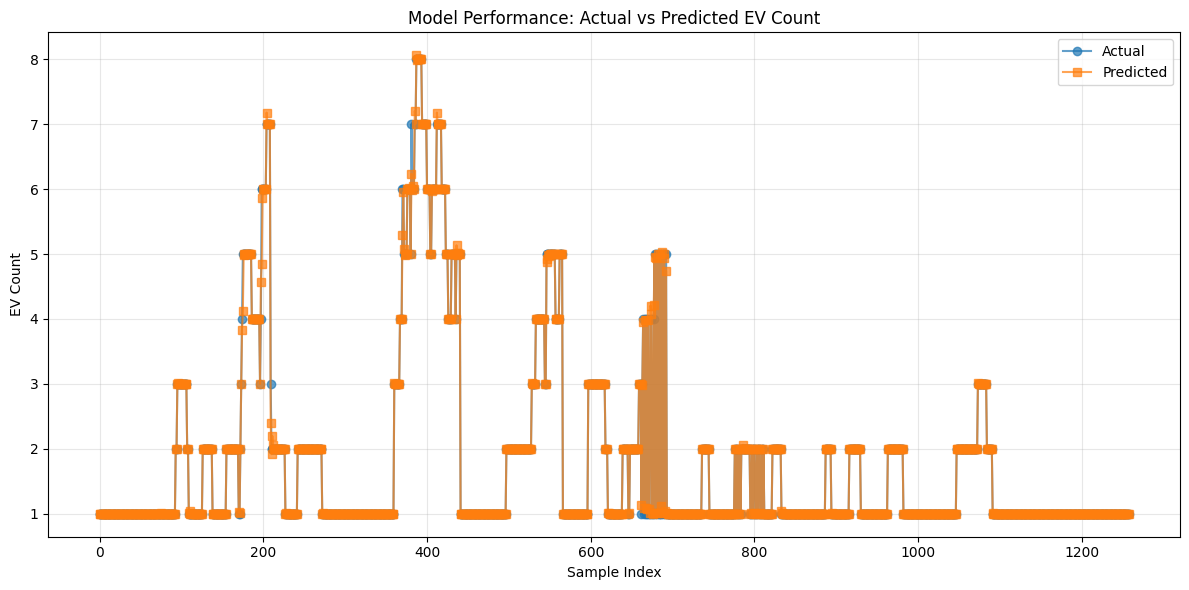

In [36]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', marker='o', alpha=0.7)
plt.plot(y_pred, label='Predicted', marker='s', alpha=0.7)
plt.title("Model Performance: Actual vs Predicted EV Count")
plt.xlabel("Sample Index")
plt.ylabel("EV Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

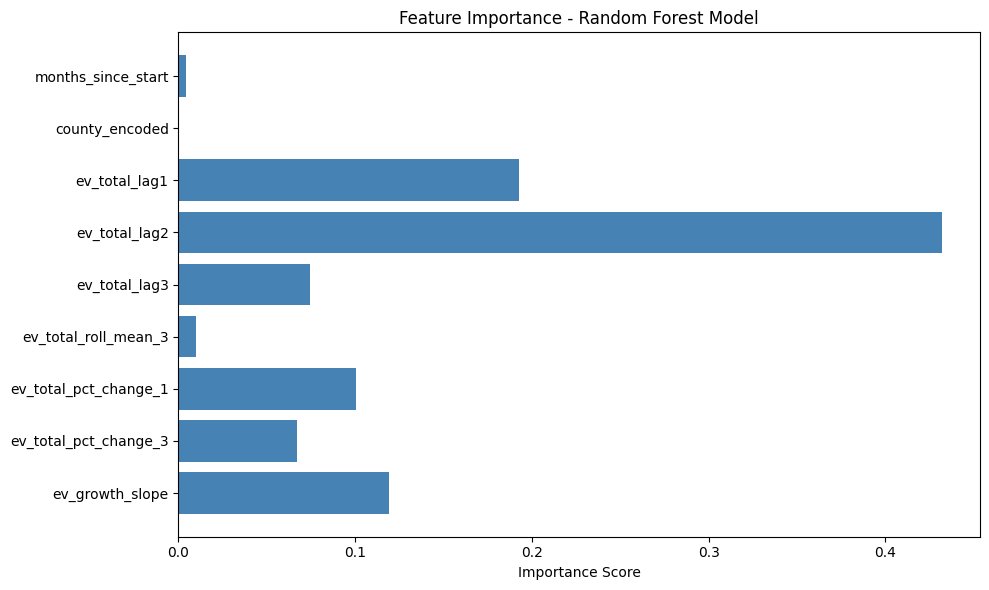

In [37]:
# Feature Importance Analysis
importances = model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='steelblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance - Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================
## **7. SINGLE COUNTY FORECASTING**
# =============================================

In [38]:
# Display available counties
print(f"\n=== Available Counties ===")
unique_counties = df['County'].dropna().unique()
print(f"Total unique counties: {len(unique_counties)}")
print(f"Sample counties: {list(unique_counties[:10])}")


=== Available Counties ===
Total unique counties: 269
Sample counties: ['Ada', 'Adams', 'Alameda', 'Albemarle', 'Alexandria', 'Allegheny', 'Allen', 'Anchorage', 'Anne Arundel', 'Arapahoe']


In [39]:
# Forecast for specific county
county = "Kings"  # Change this to any county you want to forecast

try:
    county_code = le.transform([county])[0]
    print(f"\nForecasting for '{county}' County (encoded as {county_code})")
except ValueError:
    print(f"Error: '{county}' not found. Please choose from available counties.")
    county = unique_counties[0]  # Use first available county as fallback
    county_code = le.transform([county])[0]
    print(f"Using '{county}' County instead.")


Forecasting for 'Kings' County (encoded as 130)


Generating 36-month forecast...


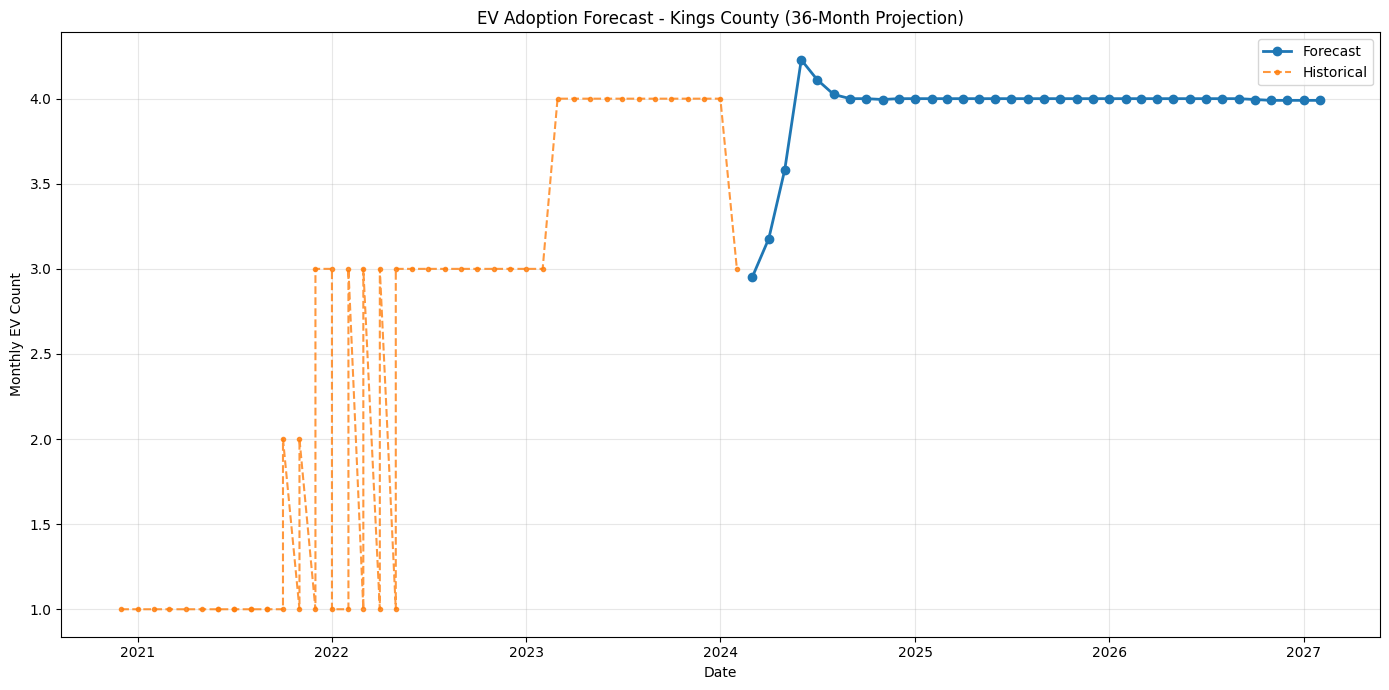

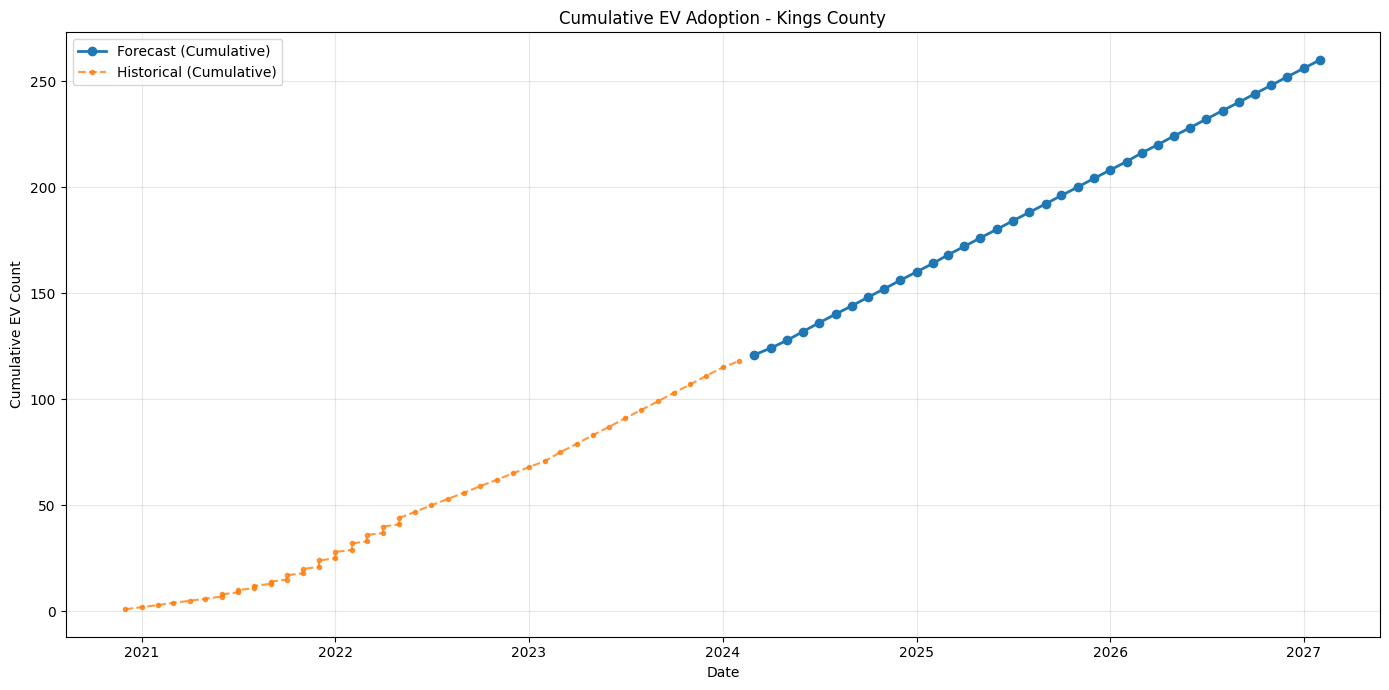

In [40]:
# Filter historical data for the county
county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")

if county_df.empty:
    print(f"Warning: No data found for county '{county}'.")
else:
    # Prepare historical data
    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    months_since_start = county_df['months_since_start'].max()

    # Historical data for plotting
    historical = county_df[['year', 'month', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))

    # Generate 36-month forecast
    latest_row = county_df.iloc[-1].copy()
    future_rows = []

    print(f"Generating 36-month forecast...")

    for i in range(1, 37):
        # Calculate next date
        next_date = pd.to_datetime(f"{latest_row['year']}-{latest_row['month']:02d}-01") + pd.DateOffset(months=1)
        y, m = next_date.year, next_date.month
        months_since_start += 1

        # Prepare features
        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        # Calculate growth slope
        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        # Create feature vector
        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        # Make prediction
        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]

        # Store forecast
        future_rows.append({
            'Date': next_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'Source': 'Forecast'
        })

        # Update rolling histories
        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

        latest_row['year'], latest_row['month'] = y, m

    # Create forecast DataFrame
    forecast_df = pd.DataFrame(future_rows)

    # Combine historical and forecast data
    historical_plot = historical[['Date', 'Electric Vehicle (EV) Total', 'months_since_start', 'Source']]
    combined = pd.concat([historical_plot, forecast_df], ignore_index=True)

    # Plot monthly forecast
    plt.figure(figsize=(14, 7))
    for source, group in combined.groupby('Source'):
        style = {'marker': 'o', 'linestyle': '-', 'linewidth': 2} if source == 'Forecast' else {'marker': '.', 'linestyle': '--', 'alpha': 0.8}
        plt.plot(group['Date'], group['Electric Vehicle (EV) Total'], label=source, **style)

    plt.title(f"EV Adoption Forecast - {county} County (36-Month Projection)")
    plt.xlabel("Date")
    plt.ylabel("Monthly EV Count")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot cumulative forecast
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

    plt.figure(figsize=(14, 7))
    for source, group in combined.groupby('Source'):
        style = {'marker': 'o', 'linestyle': '-', 'linewidth': 2} if source == 'Forecast' else {'marker': '.', 'linestyle': '--', 'alpha': 0.8}
        plt.plot(group['Date'], group['Cumulative EVs'], label=f'{source} (Cumulative)', **style)

    plt.title(f"Cumulative EV Adoption - {county} County")
    plt.xlabel("Date")
    plt.ylabel("Cumulative EV Count")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ================================================
## **8. MULTI-COUNTY FORECASTING AND RANKING**
# ==================================================

In [41]:
print(f"\n=== Generating Forecasts for All Counties ===")

forecast_horizon = 36
all_combined = []
processed_counties = 0

for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    processed_counties += 1
    if processed_counties % 10 == 0:
        print(f"Processed {processed_counties} counties...")

    # Extract county data
    months_since_start = county_df['months_since_start'].max()
    historical = county_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    future_rows = []

    # Generate forecast
    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        # Predict
        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]

        # Store forecast
        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        # Update histories
        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    # Combine data
    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()
    all_combined.append(combined)

print(f"Completed forecasts for {processed_counties} counties.")


=== Generating Forecasts for All Counties ===
Processed 10 counties...
Processed 20 counties...
Processed 30 counties...
Processed 40 counties...
Processed 50 counties...
Processed 60 counties...
Processed 70 counties...
Processed 80 counties...
Processed 90 counties...
Processed 100 counties...
Processed 110 counties...
Processed 120 counties...
Processed 130 counties...
Processed 140 counties...
Processed 150 counties...
Processed 160 counties...
Processed 170 counties...
Processed 180 counties...
Processed 190 counties...
Processed 200 counties...
Processed 210 counties...
Processed 220 counties...
Processed 230 counties...
Processed 240 counties...
Processed 250 counties...
Processed 260 counties...
Completed forecasts for 261 counties.


In [42]:
# Combine all county forecasts
full_df = pd.concat(all_combined, ignore_index=True)

# Get top 5 counties by final cumulative EV count
final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5)

print(f"\n=== Top 5 Counties by Projected Cumulative EV Adoption ===")
for i, (county, total) in enumerate(top_5_counties.items(), 1):
    print(f"{i}. {county}: {total:,.0f} EVs")


=== Top 5 Counties by Projected Cumulative EV Adoption ===
1. Santa Clara: 1,113 EVs
2. Fairfax: 1,094 EVs
3. Orange: 908 EVs
4. Los Angeles: 790 EVs
5. Honolulu: 700 EVs


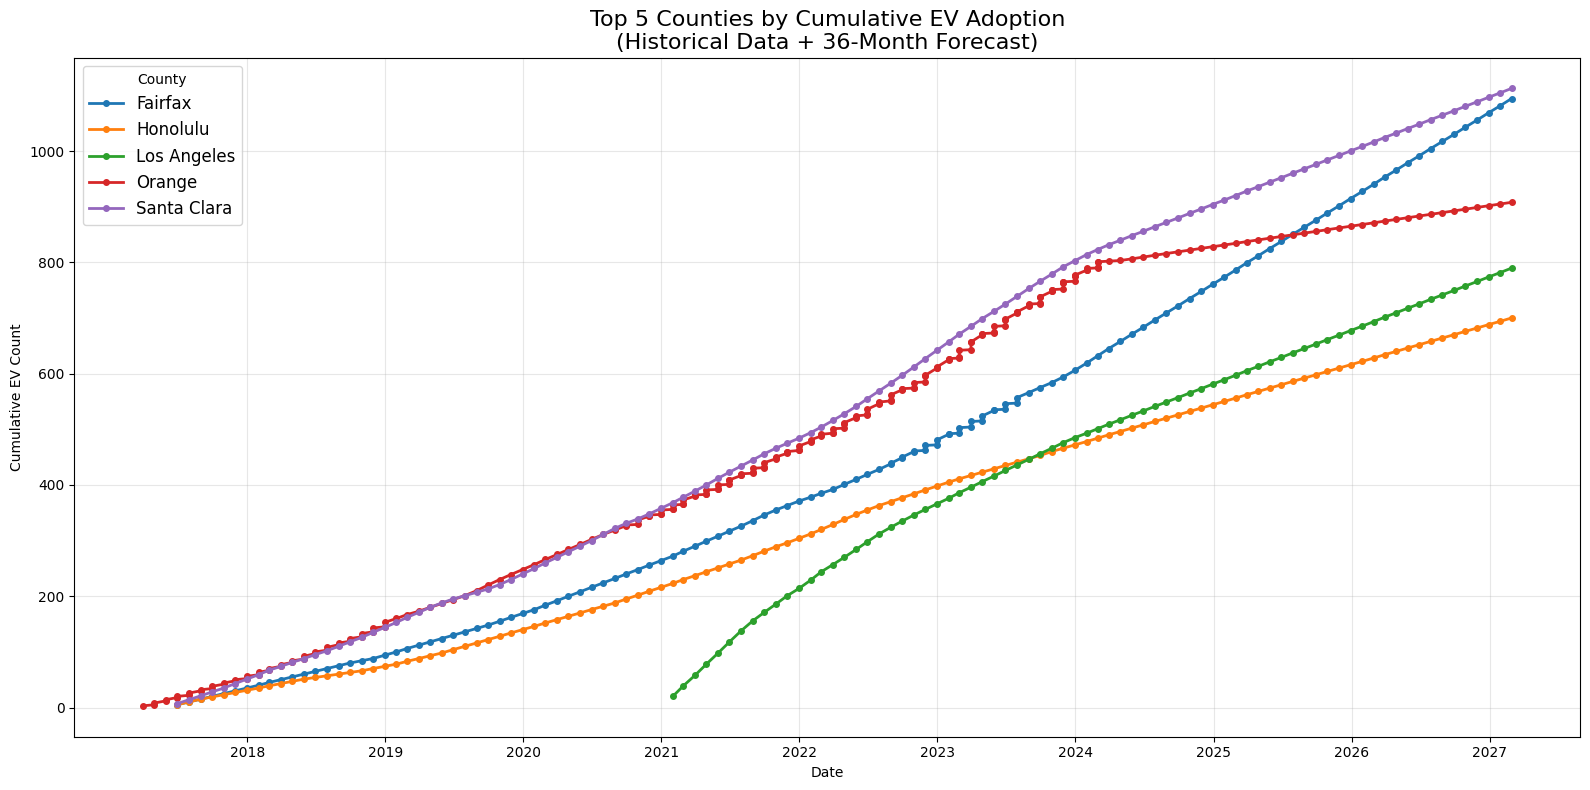

In [45]:
# Plot top 5 counties
top_5_df = full_df[full_df['County'].isin(top_5_counties.index)]

plt.figure(figsize=(16, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, (county, group) in enumerate(top_5_df.groupby('County')):
    plt.plot(group['Date'], group['Cumulative EVs'],
             label=county, marker='o', color=colors[i], linewidth=2, markersize=4)

plt.title("Top 5 Counties by Cumulative EV Adoption\n(Historical Data + 36-Month Forecast)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True, alpha=0.3)
plt.legend(title="County", fontsize=12)

# Format x-axis
years = pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')
plt.xticks(years, [str(d.year) for d in years], rotation=0)

plt.tight_layout()
plt.show()

# =================================
## **9. MODEL PERSISTENCE**
# ===================================

In [46]:
# Save the trained model to Google Drive (permanent storage)
model_path = '/content/drive/MyDrive/forecasting_ev_model.pkl'
joblib.dump(model, model_path)
print(f"\n=== Model Saved ===")
print(f"Model saved to: {model_path}")

# Save label encoder to Google Drive
le_path = '/content/drive/MyDrive/label_encoder.pkl'
joblib.dump(le, le_path)
print(f"Label encoder saved to: {le_path}")

# Also save to local session (temporary)
local_model_path = '/content/forecasting_ev_model.pkl'
local_le_path = '/content/label_encoder.pkl'
joblib.dump(model, local_model_path)
joblib.dump(le, local_le_path)
print(f"Backup copies saved locally in /content/")


=== Model Saved ===
Model saved to: /content/drive/MyDrive/forecasting_ev_model.pkl
Label encoder saved to: /content/drive/MyDrive/label_encoder.pkl
Backup copies saved locally in /content/


In [47]:
# Test model loading
loaded_model = joblib.load(model_path)
loaded_le = joblib.load(le_path)
print(f"\nModel loaded successfully from Google Drive.")


Model loaded successfully from Google Drive.


In [48]:
# Quick test prediction
if len(X_test) > 0:
    sample = X_test.iloc[[0]]
    true_value = y_test.iloc[0]
    predicted_value = loaded_model.predict(sample)[0]

    print(f"\n=== Model Test ===")
    print(f"Test Sample - Actual: {true_value:.2f}, Predicted: {predicted_value:.2f}")
    print(f"Prediction Error: {abs(true_value - predicted_value):.2f}")

print(f"\n=== Analysis Complete ===")
print(f"✅ Data preprocessing completed")
print(f"✅ Model trained and evaluated")
print(f"✅ Single county forecast generated")
print(f"✅ Multi-county analysis completed")
print(f"✅ Model saved for future use")


=== Model Test ===
Test Sample - Actual: 1.00, Predicted: 1.00
Prediction Error: 0.00

=== Analysis Complete ===
✅ Data preprocessing completed
✅ Model trained and evaluated
✅ Single county forecast generated
✅ Multi-county analysis completed
✅ Model saved for future use
